In [43]:
!pip install transformers
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [67]:
import pandas as pd
import numpy as np
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
from sklearn import metrics

In [45]:
df = pd.read_csv("./sst_dataset/SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/datasetSentences.txt", sep="\t", index_col=0)

dictionary = pd.read_csv("./sst_dataset/SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/dictionary.txt", sep="|", index_col=1, header=None)

label = pd.read_csv("./sst_dataset/SST2-Data/SST2-Data/stanfordSentimentTreebank/stanfordSentimentTreebank/sentiment_labels.txt", sep="|", index_col=0)

In [46]:
df

,sentence
sentence_index,
1,The Rock is destined to be the 21st Century 's...
2,The gorgeously elaborate continuation of `` Th...
3,Effective but too-tepid biopic
4,If you sometimes like to go to the movies to h...
5,"Emerges as something rare , an issue movie tha..."
...,...
11851,A real snooze .
11852,No surprises .
11853,We 've seen the hippie-turned-yuppie plot befo...


In [47]:
label

,sentiment values
phrase ids,
0,0.50000
1,0.50000
2,0.44444
3,0.50000
4,0.42708
...,...
239227,0.36111
239228,0.38889
239229,0.33333


In [48]:
dictionary = dictionary.sort_index()
dictionary

,0
1,
0,!
1,'
2,' (
3,' ( the cockettes
4,' ( the cockettes )
...,...
239227,your standard Hollywood bio-pic
239228,your typical ` fish out of water ' story
239229,zero .


In [49]:
data = pd.merge(dictionary, label, left_index=True, right_index=True)
data

,0,sentiment values
1,,
0,!,0.50000
1,',0.50000
2,' (,0.44444
3,' ( the cockettes,0.50000
4,' ( the cockettes ),0.42708
...,...,...
239227,your standard Hollywood bio-pic,0.36111
239228,your typical ` fish out of water ' story,0.38889
239229,zero .,0.33333


In [50]:
# transform it to a dictionary with 'label and 'text'
data = data.reset_index()
data = data.rename(columns={ 0:'text', 'sentiment values':'label'})
data = data.drop(1, axis=1)
data = data[['label', 'text']]
data = data.dropna()
data = data.sample(n=10000,random_state=42)

In [51]:
#change the label to 5 classes 0-0.2 for 0, 0.2-0.4 for 1, 0.4-0.6 for 2, 0.6-0.8 for 3, 0.8-1 for 4
#change the label to 5 classes 0-0.2 for 0, 0.2-0.4 for 1, 0.4-0.6 for 2, 0.6-0.8 for 3, 0.8-1 for 4
def change_label(x):
    if x <= 0.2:
        return 0
    elif x <= 0.4:
        return 1
    elif x <= 0.6:
        return 2
    elif x <= 0.8:
        return 3
    else:
        return 4
data['label'] = data['label'].apply(change_label)
data['label'] = data['label'].dropna()
data['text'] = data['text'].dropna()

In [52]:
X= list(data['text'])
y= list(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

In [53]:
len(X_train)

8000

In [54]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

train_encodings = tokenizer(X_train, truncation=True,padding=True)
test_encodings = tokenizer(X_test,truncation=True,padding=True)

In [55]:
"""from torch.utils.data import Dataset

class TokenizedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
"""

"from torch.utils.data import Dataset\n\nclass TokenizedDataset(Dataset):\n    def __init__(self, encodings, labels):\n        self.encodings = encodings\n        self.labels = labels\n\n    def __getitem__(self, idx):\n        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}\n        item['labels'] = torch.tensor(self.labels[idx])\n        return item\n\n    def __len__(self):\n        return len(self.labels)\n"

In [56]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
"""# Assume `encodings` is your tokenized data and `labels` are your numerical labels
train_dataset = TokenizedDataset(train_encodings, y_train)
test_dataset = TokenizedDataset(test_encodings, y_test)
"""
train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": y_train})
test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"], "labels": y_test})

In [57]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [59]:
training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch", 
    num_train_epochs=10,     
)

In [60]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=test_dataset, 
    compute_metrics=compute_metrics, 
)

In [61]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,1.027900,0.988936,0.583000
2,0.716800,1.010859,0.613000
3,0.456500,1.313924,0.590000
4,0.285400,1.606921,0.563500
5,0.200200,1.856748,0.606500
6,0.129600,2.267806,0.583500
7,0.071300,2.667086,0.601000
8,0.035600,3.013368,0.600500
9,0.020300,3.067548,0.609000
10,0.007500,3.153345,0.607500


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory test_trainer/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were sc

TrainOutput(global_step=5000, training_loss=0.2951185815811157, metrics={'train_runtime': 1229.6437, 'train_samples_per_second': 65.059, 'train_steps_per_second': 4.066, 'total_flos': 2590069214880000.0, 'train_loss': 0.2951185815811157, 'epoch': 10.0})

In [62]:
trainer.evaluate(test_dataset)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 3.1533446311950684,
 'eval_accuracy': 0.6075,
 'eval_runtime': 9.4902,
 'eval_samples_per_second': 210.744,
 'eval_steps_per_second': 13.171,
 'epoch': 10.0}

In [70]:
predictions = trainer.predict(test_dataset)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [71]:
# Convert the predictions to the same format as your labels
# This depends on your specific use case
# For example, if you're doing classification, you might want to use the argmax
predicted_labels = predictions.predictions.argmax(-1)

# Get the true labels

# Create a DataFrame to compare the predicted and true labels
import pandas as pd
results = pd.DataFrame({
    'Predicted Label': predicted_labels,
    'True Label': y_test
})

print(results)


      Predicted Label  True Label
0                   0           0
1                   2           2
2                   3           2
3                   3           4
4                   2           2
...               ...         ...
1995                2           1
1996                1           2
1997                2           1
1998                2           2
1999                3           3

[2000 rows x 2 columns]


In [72]:
precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true=y_test, y_pred=predicted_labels, average='macro')
precision, recall, f1

(0.5235071759181384, 0.49597739058149265, 0.5051045305473674)

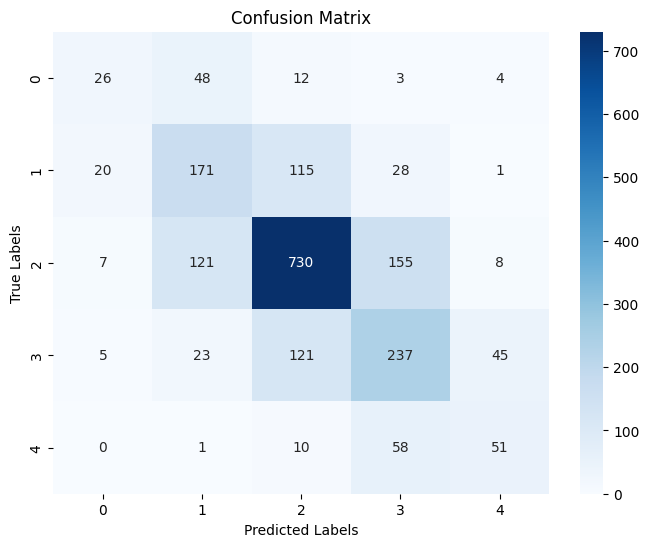

In [73]:
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = predicted_labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

classes = [0,1,2,3,4]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()